<a href="https://colab.research.google.com/github/Satwikram/Sign-Language-Prediction/blob/main/Sign%20Language%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram K

### Connecting to Kaggle

In [ ]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset

 98% 187M/191M [00:01<00:00, 113MB/s] 
100% 191M/191M [00:01<00:00, 104MB/s]


### Unzipping the dataset

In [ ]:
! unzip /content/sign-language-gesture-images-dataset.zip

### Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

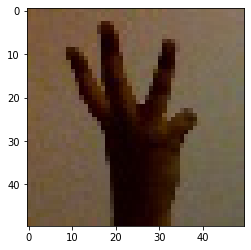

In [ ]:
plt.imshow(plt.imread("/content/Gesture Image Data/6/1.jpg"))

### Load all the Images

In [ ]:
uniq_labels = sorted(os.listdir('/content/Gesture Image Pre-Processed Data'))

In [ ]:
uniq_labels[4]

'4'

In [ ]:
def load_dataset(directory):

  images = []
  labels = []

 
  for idx, label in tqdm(enumerate(uniq_labels)):
    for file in os.listdir(directory+label):
      filepath = directory+label+"/"+file
      img = cv2.resize(cv2.imread(filepath),(50,50))
      images.append(img)
      labels.append(idx)

  images = np.asarray(images)
  labels = np.asarray(labels)
  return images, labels

### Loading Dataset

In [ ]:
X, y = load_dataset('/content/Gesture Image Data/')

37it [00:05,  6.44it/s]


In [ ]:
X.shape, y.shape

((55500, 50, 50, 3), (55500,))

In [ ]:
y[1499]

0

### Converting to Categorical

In [ ]:
y = tf.keras.utils.to_categorical(y, num_classes = len(uniq_labels))

In [ ]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

### Normalizing the Images

In [ ]:
X = X / 255.0

In [ ]:
X[0]

array([[[0.19215686, 0.34509804, 0.47058824],
        [0.21176471, 0.36078431, 0.48627451],
        [0.24705882, 0.38039216, 0.49803922],
        ...,
        [0.3254902 , 0.45098039, 0.5254902 ],
        [0.3372549 , 0.43921569, 0.50588235],
        [0.34901961, 0.44313725, 0.51372549]],

       [[0.20392157, 0.34117647, 0.47058824],
        [0.20784314, 0.34509804, 0.4745098 ],
        [0.24313725, 0.36470588, 0.48627451],
        ...,
        [0.32941176, 0.44705882, 0.52156863],
        [0.34901961, 0.44313725, 0.51372549],
        [0.36078431, 0.44705882, 0.51764706]],

       [[0.24313725, 0.35294118, 0.48627451],
        [0.23921569, 0.34901961, 0.48235294],
        [0.25098039, 0.36470588, 0.48627451],
        ...,
        [0.34509804, 0.43921569, 0.51764706],
        [0.36862745, 0.44705882, 0.51764706],
        [0.37647059, 0.44705882, 0.51372549]],

       ...,

       [[0.23137255, 0.31372549, 0.42352941],
        [0.24705882, 0.32941176, 0.43529412],
        [0.23137255, 0

### Splitting Data into train and test

In [ ]:
len(X)*0.05

2775.0

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 388)

In [ ]:
import random

In [ ]:

np.argmax(y_test[100])

18

TypeError: ignored

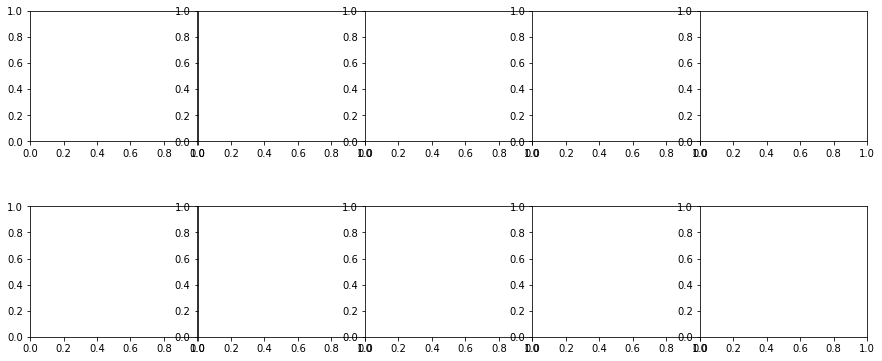

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i in range(10):

  num = random.randint(0, 2775)
  axs[i].contourf(X_test[num])
  axs[i].set_title(np.argmax(y_test[num]))

In [ ]:
a = np.array([1])

In [ ]:
b = np.asarray([1])

In [ ]:
 a == b

array([ True])